In [1]:
import mne
import numpy as np 
import matplotlib.pyplot as plt
import math
from scipy import signal

import warnings
warnings.filterwarnings('ignore')

In [2]:
# define it heve to be able to use at problem 12
def get_data_from_timerange(evoked, tmin=0, tmax=1):
    data = evoked.data
    times = evoked.times
    mask = (times >= tmin) & (times < tmax) 
    return data[:, mask]
    
def minmax_norm(evoked):
    data = get_data_from_timerange(evoked, tmin=0.3, tmax=0.4)
    
    minmax_norm = (data.mean(1) - data.mean(1).min()) / (data.mean(1).max() - data.mean(1).min())
    
    return minmax_norm, data

# Problem 11. Auditory Oddball paradigm

## Data Information
This data contains 2 sessions, been down-sampled to 250Hz, and been band-pass filtered.  

|Trigger|Event|
|---|---|
|10|Response|
|2|High pitch|
|3|Low pitch|
|4|End of session|

In [3]:
filename = 'Day 1_ERP.set'

#load eeg data 
epochs = mne.io.read_epochs_eeglab(filename)

Extracting parameters from Day 1_ERP.set...
Not setting metadata
Not setting metadata
500 matching events found
No baseline correction applied
0 projection items activated
Ready.


### (a) Range of band-pass

    Using multitaper spectrum estimation with 7 DPSS windows


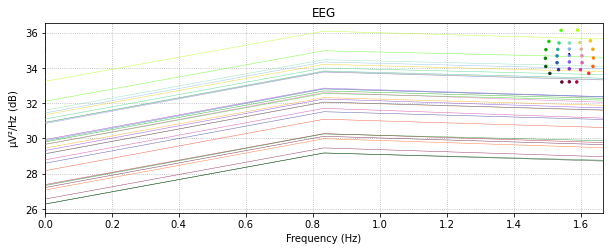

    Using multitaper spectrum estimation with 7 DPSS windows


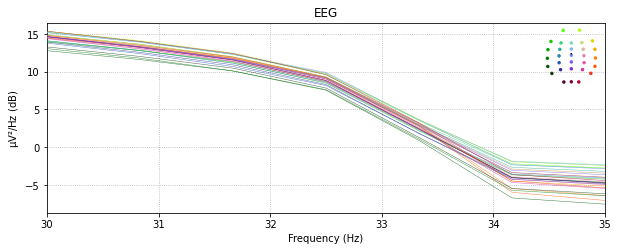

    Using multitaper spectrum estimation with 7 DPSS windows


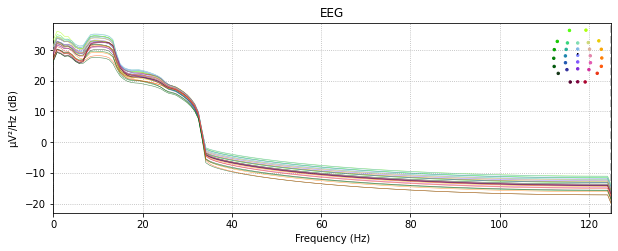

In [4]:
epochs.plot_psd(average=False, fmin=0, fmax=2)
plt.show()

epochs.plot_psd(average=False, fmin=30, fmax=35)
plt.show()

epochs.plot_psd(average=False)
plt.show()

Its look like low-pass of 32 Hz if we take slope of the filter into consideration.   
But if it band-pass then I would say from 0.8-32 Hz based on figures above.


### (b) Portion of High Pitch: Low pitch

In [5]:
print('Event mapping:')
print(epochs.event_id)

Event mapping:
{'2': 1, '3/10': 2, '2/10': 3, '3': 4, '2/4': 5}


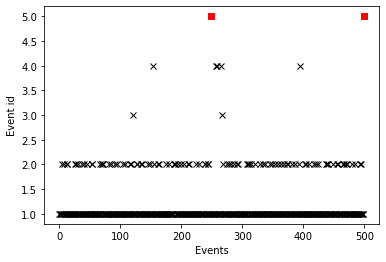


Session 1:
	Event index: 249
	Event timestemp: 74751

Session 2:
	Event index: 499
	Event timestemp: 149751



In [6]:
# Read all events ids
events_ids = epochs.events[:,2]
events_time = epochs.events[:,0]
idx = np.where(events_ids == 5)[0]

# Determine where event equals 5 (End of session)
# fig = mne.viz.plot_events(epochs.events, sfreq=epochs.info['sfreq'], event_id=epochs.event_id)
# fig.subplots_adjust(right=0.7)  # make room for legend
plt.plot(events_ids, 'xk')
plt.plot(np.ma.masked_where(events_ids != 5, events_ids) , 'sr')
plt.xlabel('Events')
plt.ylabel('Event id')
plt.show()

print('''
Session 1:
\tEvent index: {}
\tEvent timestemp: {}

Session 2:
\tEvent index: {}
\tEvent timestemp: {}
'''.format(idx[0], events_time[idx[0]], idx[1], events_time[idx[1]]))


In [7]:
low_count = ((events_ids == 1) | (events_ids == 3) | (events_ids == 5)).sum()
high_count = ((events_ids == 2) | (events_ids == 4)).sum()

print(f'Portion of Low Pitch: {low_count}')
print(f'Portion of High Pitch: {high_count}')

Portion of Low Pitch: 400
Portion of High Pitch: 100


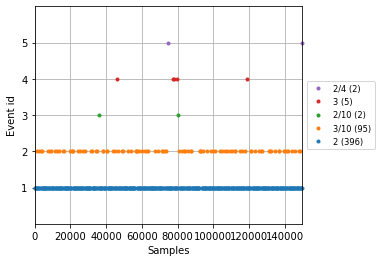

In [8]:
mne.viz.plot_events(epochs.events, event_id=epochs.event_id); plt.show()

### (c) Plot the Fz, Cz, and Pz’s average ERP for Response respectively.

In [9]:
print(epochs.ch_names)

['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FT7', 'FC3', 'FCZ', 'FC4', 'FT8', 'T3', 'C3', 'CZ', 'C4', 'T4', 'TP7', 'CP3', 'CPZ', 'CP4', 'TP8', 'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'OZ', 'O2']


In [10]:
# Get all event ids that contained 10 (e.g. Response)
event_ids = [id for id in list(epochs.event_id.keys()) if '10' in id]

In [11]:
picked_channels = {'fz':None, 'cz':None, 'pz':None, 'all':None}
picked_channels['fz'] = epochs.copy().pick_channels(['FZ'])
picked_channels['cz'] = epochs.copy().pick_channels(['CZ'])
picked_channels['pz'] = epochs.copy().pick_channels(['PZ'])
picked_channels['all'] = epochs.copy().pick_channels(['FZ', 'CZ', 'PZ'])

evoked = {}
for k, channel in picked_channels.items():
    # Event id 10 corresponds to Response
    
    evoked[k] = channel[event_ids].average()


Average ERP for Response:


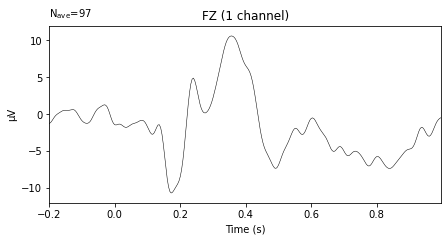

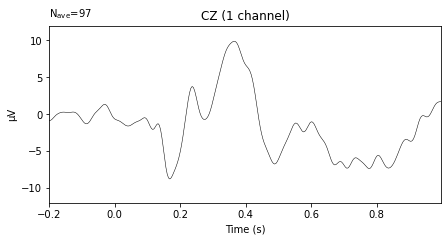

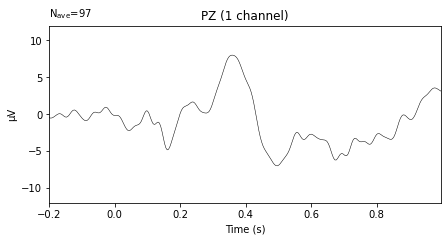

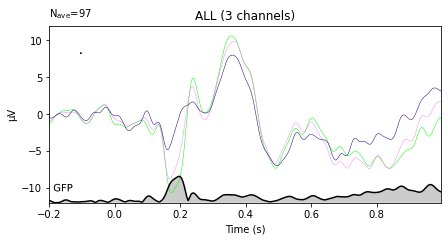

In [12]:
print('Average ERP for Response:')
def plot_avg_erp(evoked):
    for k, evok in evoked.items():
        if k == 'all':
            evok.plot(spatial_colors=True, gfp=True, titles=k.upper(),ylim=dict(eeg=[-12, 12]))
        else:
            evok.plot(titles=k.upper(),ylim=dict(eeg=[-12, 12]), selectable=False)

        plt.show()
plot_avg_erp(evoked)

### (d) Plot the Fz, Cz, and Pz’s average ERP for High pitch and Low pitch respectively.

In [13]:
# Get all event ids that contained to 2 and 3 (e.g. Hihg and Low)
event_ids_low  = [id for id in list(epochs.event_id.keys()) if '3' in id]
event_ids_high = [id for id in list(epochs.event_id.keys()) if '2' in id]
event_ids_low, event_ids_high

(['3/10', '3'], ['2', '2/10', '2/4'])

In [14]:
evoked_low = {}
evoked_high = {}
for k, channel in picked_channels.items():
    # Event id 2 corresponds to High. Event id 3 corresponds to Low
    evoked_low[k] = channel[event_ids_low].average()
    evoked_high[k] = channel[event_ids_high].average()

Average ERP for Low:


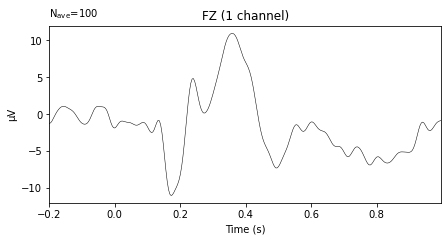

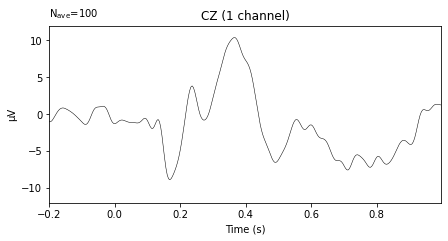

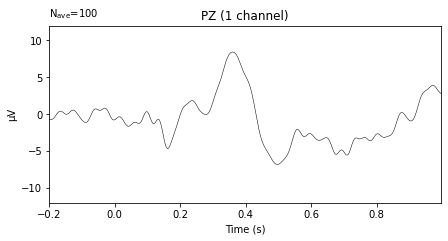

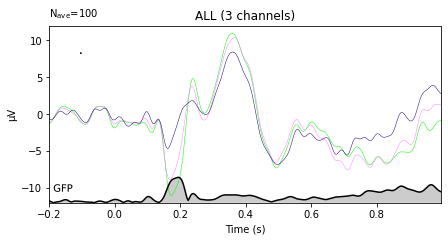

In [15]:
print('Average ERP for Low:')
plot_avg_erp(evoked_low)

Average ERP for High:


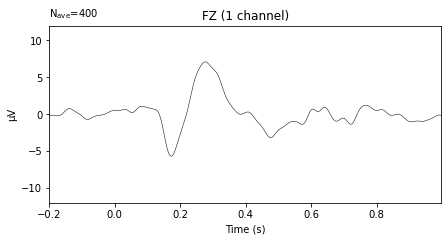

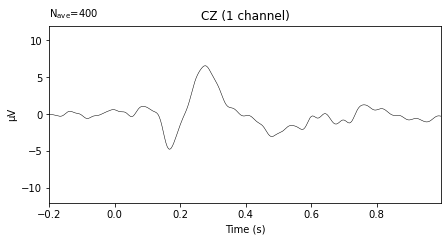

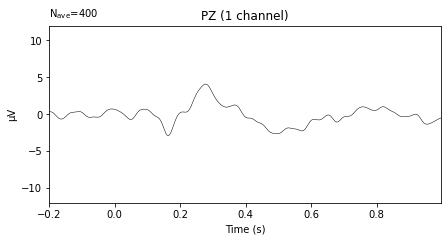

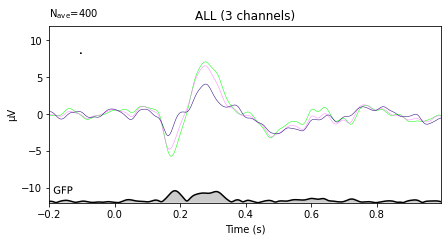

In [16]:
print('Average ERP for High:')
plot_avg_erp(evoked_high)

### (e) Plot topoplot for High pitch and Low pitch respectively

In [17]:
evoked_low = epochs.copy()[event_ids_low].average()
evoked_high = epochs.copy()[event_ids_high].average()

In [18]:
onset_time_start = (evoked_low.times < 0).sum()
evoked_low.data = evoked_low.data[:,onset_time_start:]
evoked_high.data = evoked_high.data[:,onset_time_start:]

evoked_low.times = evoked_low.times[onset_time_start:]
evoked_high.times = evoked_high.times[onset_time_start:]


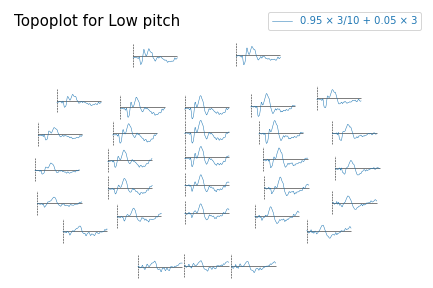

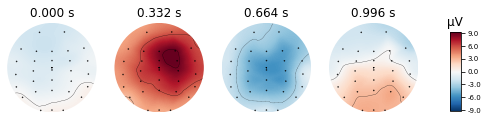

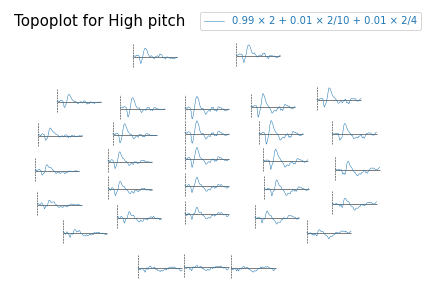

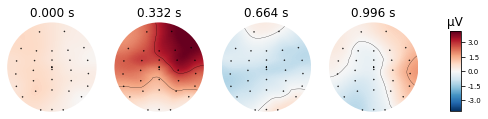

In [19]:
title = 'Topoplot for Low pitch'
evoked_low.plot_topo(title=title); plt.show()
evoked_low.plot_topomap(); plt.show()

title = 'Topoplot for High pitch'  
evoked_high.plot_topo(title=title); plt.show()
evoked_high.plot_topomap(); plt.show()

### (f) Plot topoplot for High pitch and Low pitch respectively with Min-Max normalization.

In [20]:
evoked_low = epochs.copy()[event_ids_low].average()
evoked_high = epochs.copy()[event_ids_high].average()

In [21]:
def get_data_from_timerange(evoked, tmin=0, tmax=1):
    data = evoked.data
    times = evoked.times
    mask = (times >= tmin) & (times < tmax) 
    return data[:, mask]
    
def minmax_norm(evoked):
    data = get_data_from_timerange(evoked, tmin=0.3, tmax=0.4)
    
    minmax_norm = (data.mean(1) - data.mean(1).min()) / (data.mean(1).max() - data.mean(1).min())
    
    return minmax_norm, data
    
low_norm, low_p300   = minmax_norm(evoked_low)
high_norm, high_p300 = minmax_norm(evoked_high)

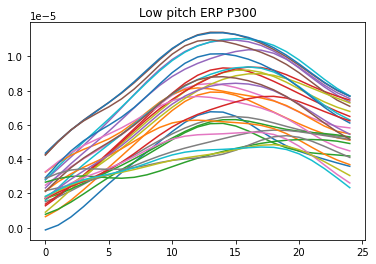

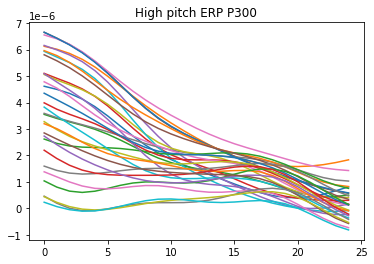

In [22]:
plt.title('Low pitch ERP P300')
plt.plot(low_p300.T); plt.show()
plt.title('High pitch ERP P300')
plt.plot(high_p300.T); plt.show()

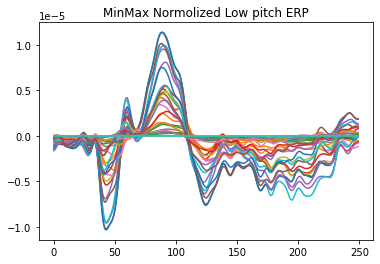

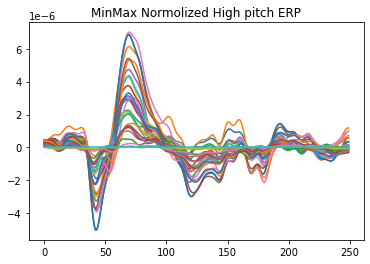

In [23]:
plt.title('MinMax Normolized Low pitch ERP')
plt.plot(evoked_low.data.T[50:]*low_norm); plt.show()
plt.title('MinMax Normolized High pitch ERP')
plt.plot(evoked_high.data.T[50:]*high_norm); plt.show()

In [24]:
onset_time_start = (evoked_low.times < 0).sum()

evoked_low.data = (evoked_low.data.T[onset_time_start:]*low_norm).T
evoked_high.data = (evoked_high.data.T[onset_time_start:]*high_norm).T

evoked_low.times = evoked_low.times[onset_time_start:]
evoked_high.times = evoked_high.times[onset_time_start:]

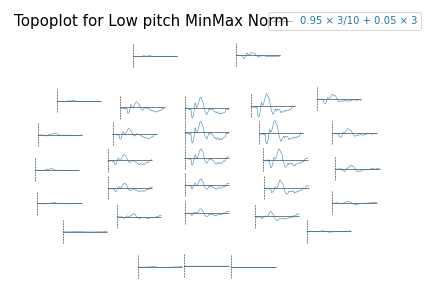

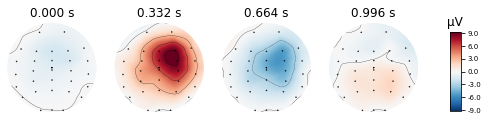

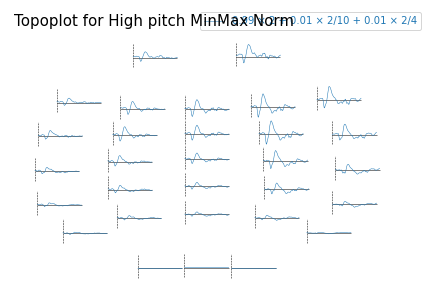

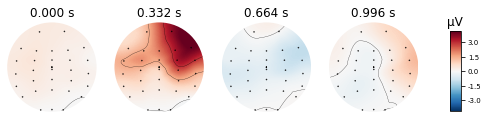

In [25]:
title = 'Topoplot for Low pitch MinMax Norm'
evoked_low.plot_topo(title=title); plt.show()
evoked_low.plot_topomap(); plt.show()

title = 'Topoplot for High pitch MinMax Norm'  
evoked_high.plot_topo(title=title); plt.show()
evoked_high.plot_topomap(); plt.show()

### (g) For each channel, plot SNR for High picth and Low pitch.

This is the first way to visualize it.

In [26]:
evoked_low = epochs.copy()[event_ids_low].average()
evoked_high = epochs.copy()[event_ids_high].average()

In [27]:
low_baseline = get_data_from_timerange(evoked_low, -0.2, 0.0)
low_p300_data = get_data_from_timerange(evoked_low, 0.3, 0.4)

high_baseline = get_data_from_timerange(evoked_high, -0.2, 0.0)
high_p300_data = get_data_from_timerange(evoked_high, 0.3, 0.4)


In [28]:
snr_low = low_p300_data.mean(1) / low_baseline.std(1)
snr_high = high_p300_data.mean(1) / high_baseline.std(1)

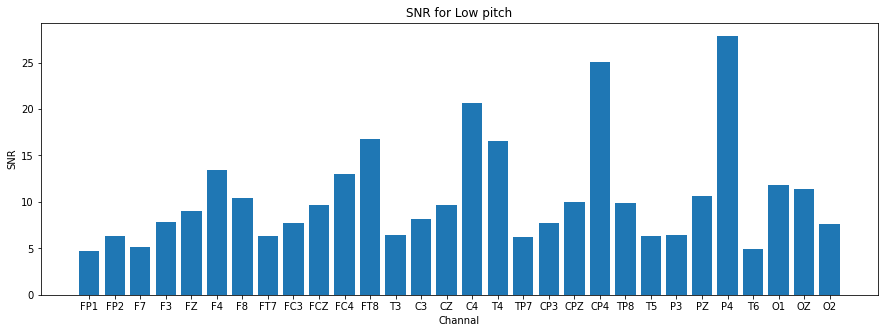

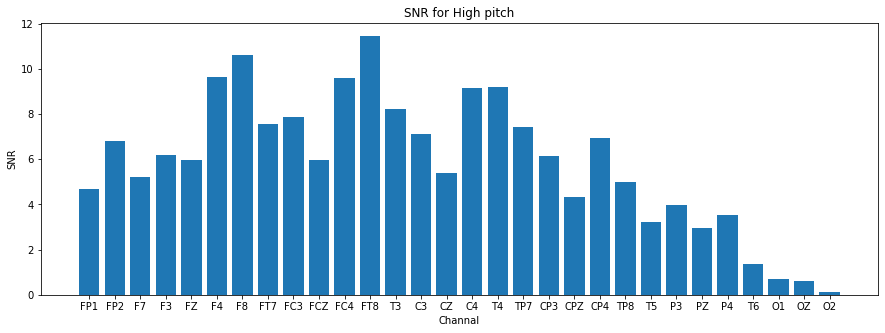

In [29]:
plt.figure(figsize=(15,5))
plt.bar(epochs.ch_names, snr_low)
plt.title('SNR for Low pitch')
plt.xlabel('Channal')
plt.ylabel('SNR')
plt.show()

plt.figure(figsize=(15,5))
plt.bar(epochs.ch_names, snr_high)
plt.title('SNR for High pitch')
plt.xlabel('Channal')
plt.ylabel('SNR')
plt.show()

This is the second way to visualize it.

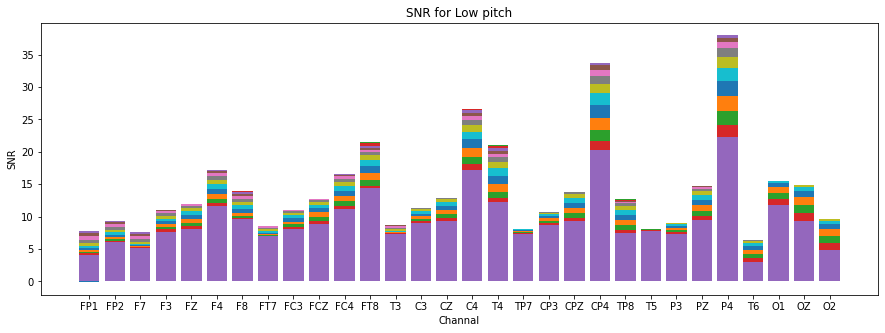

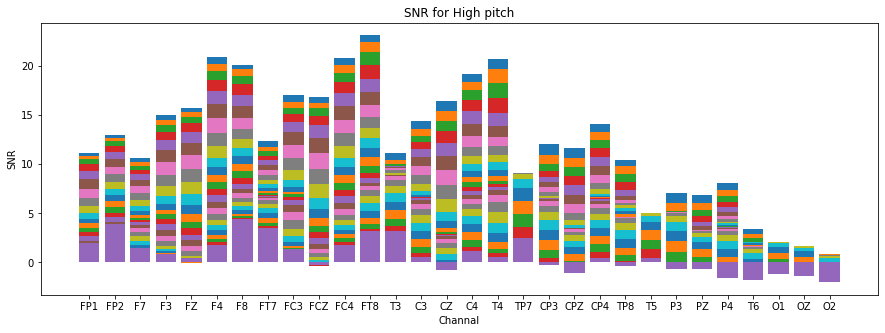

In [30]:
evoked_low = epochs.copy()[event_ids_low].average()
evoked_high = epochs.copy()[event_ids_high].average()

def plot_snr_full(evoked, epochs, title):
    baseline = evoked.data[:, evoked.times < 0]
    p300 = get_data_from_timerange(evoked, tmin=.3, tmax=.4)

    SNR = (p300.T / baseline.std(1))
    plt.figure(figsize=(15,5))
    plt.title(title)
    plt.xlabel('Channal')
    plt.ylabel('SNR')
    for snr in SNR: 
        plt.bar(epochs.ch_names, snr)

    plt.show()
    
plot_snr_full(evoked_low, epochs, 'SNR for Low pitch')
plot_snr_full(evoked_high, epochs, 'SNR for High pitch')

### (h) Plot cumulative (by trial) SNR for Fz, Cz, and Pz channel

In [31]:
baselines = np.zeros((500, 30, 51))

for i in range(500):
    baselines[i] = epochs[i].get_data()[0][:,:51]

In [32]:
P300s = np.zeros((500, 30, 25))

for i in range(500):
    mask = (epochs[i].times >= 0.3) & (epochs[i].times < 0.4) 
    P300s[i] = epochs[i].get_data()[0][:, mask]

In [33]:
SNRs = np.zeros((500, 30))

for i in range(500):
    SNRs[i] = P300s[i].mean(1) / baselines[i].std(1)

In [34]:
cumsum_trail = np.cumsum(SNRs, axis=0)

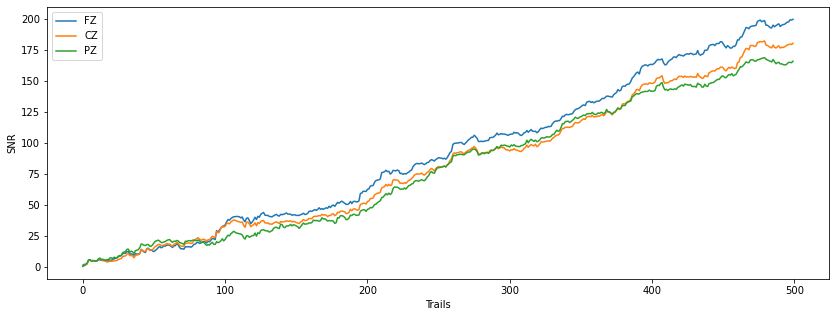

In [35]:
fz_idx = np.where(np.array(epochs.ch_names) == 'FZ')[0][0]
cz_idx = np.where(np.array(epochs.ch_names) == 'CZ')[0][0]
pz_idx = np.where(np.array(epochs.ch_names) == 'PZ')[0][0]

plt.figure(figsize=(14,5))
plt.plot(cumsum_trail[:,fz_idx], label='FZ')
plt.plot(cumsum_trail[:,cz_idx], label='CZ')
plt.plot(cumsum_trail[:,pz_idx], label='PZ')
plt.xlabel('Trails')
plt.ylabel('SNR')
plt.legend()
plt.show()

# Problem 12. 5 target SSVEP paradigm

In [36]:
#load eeg data 
raw = mne.io.read_epochs_eeglab('Day 2_SSVEP.set')

Extracting parameters from Day 2_SSVEP.set...
Not setting metadata
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [37]:
raw.event_id

{'21': 1, '11': 2, '51': 3, '41': 4, '31': 5}

In [38]:
raw.event_id = {'10Hz': 2, '11Hz': 1, '12Hz': 5,
              '13Hz': 4, 'Nan': 3}

### a) For Fz and Oz, plot average ERP for each type of stimuli.

In [39]:
# Channals picking
FZ = raw.copy()
OZ = raw.copy()

inst_oz = OZ.pick_channels(['OZ'])
inst_fz = FZ.pick_channels(['FZ'])

Need more than one channel to make topography for eeg. Disabling interactivity.


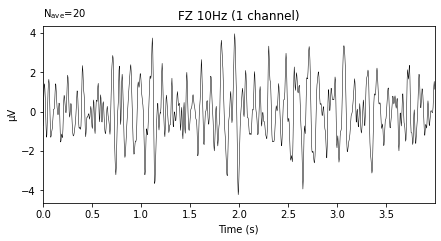

Need more than one channel to make topography for eeg. Disabling interactivity.


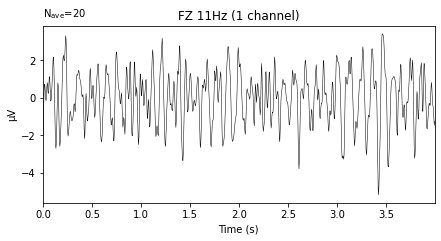

Need more than one channel to make topography for eeg. Disabling interactivity.


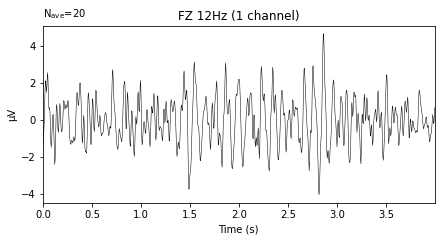

Need more than one channel to make topography for eeg. Disabling interactivity.


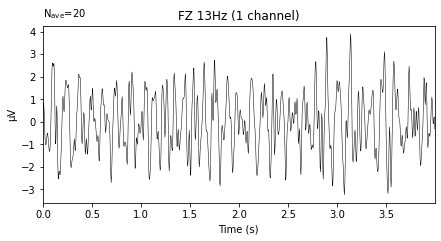

Need more than one channel to make topography for eeg. Disabling interactivity.


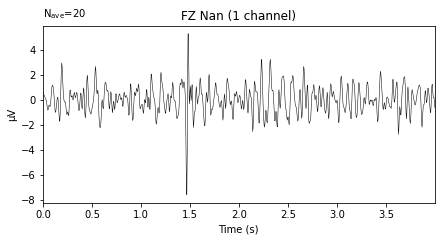

Need more than one channel to make topography for eeg. Disabling interactivity.


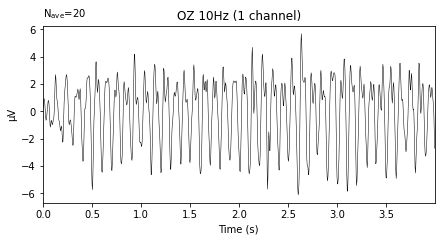

Need more than one channel to make topography for eeg. Disabling interactivity.


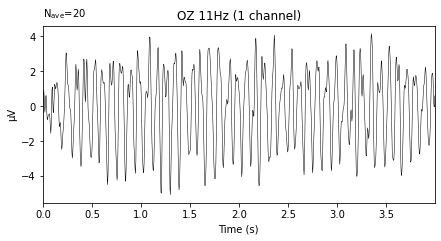

Need more than one channel to make topography for eeg. Disabling interactivity.


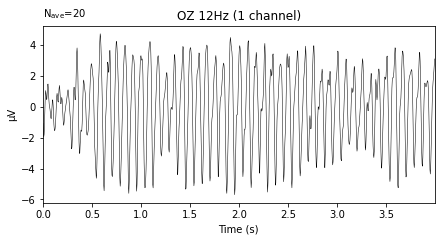

Need more than one channel to make topography for eeg. Disabling interactivity.


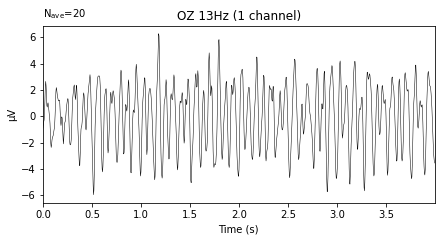

Need more than one channel to make topography for eeg. Disabling interactivity.


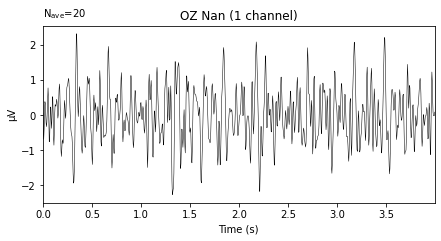

In [40]:
# plot 
FZ_ave_erp= [FZ[i].average().plot(titles='FZ '+i) for i in raw.event_id.keys()]
OZ_ave_erp= [OZ[i].average().plot(titles='OZ '+i) for i in raw.event_id.keys()]

### b) Plot power v.s. frequency for each stimuli at Fz and Oz channel 

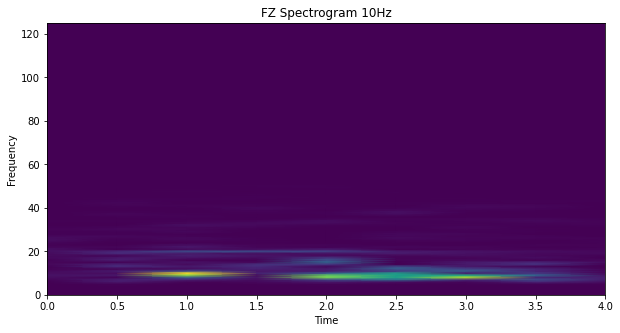

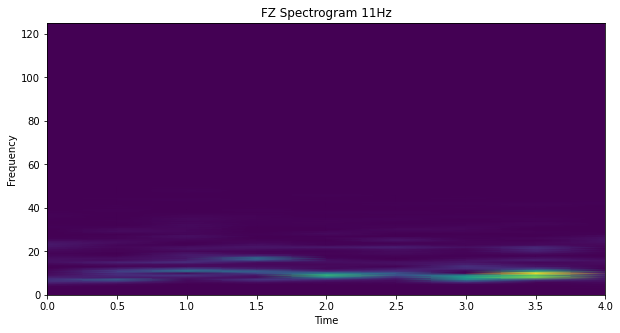

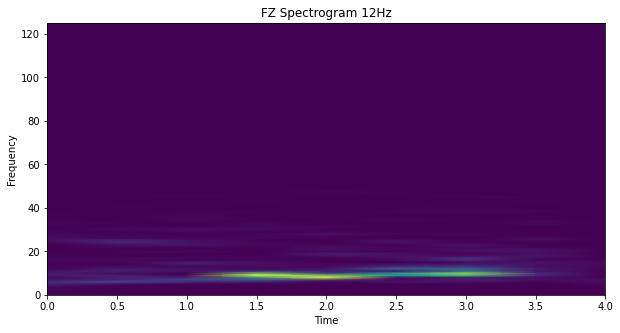

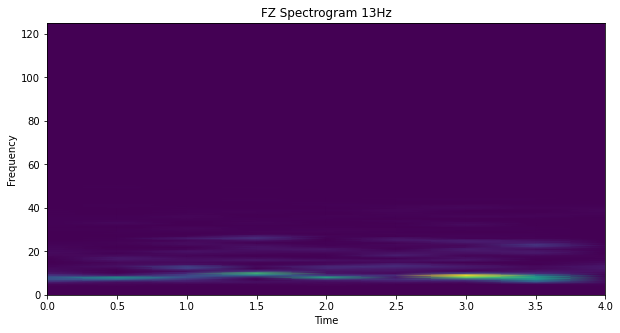

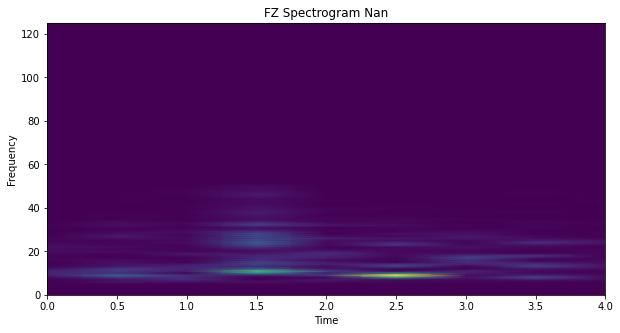

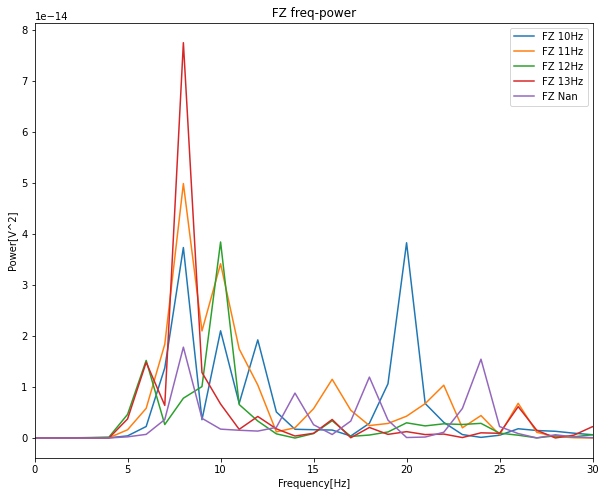

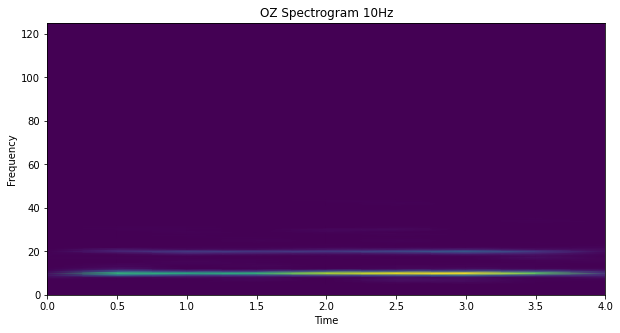

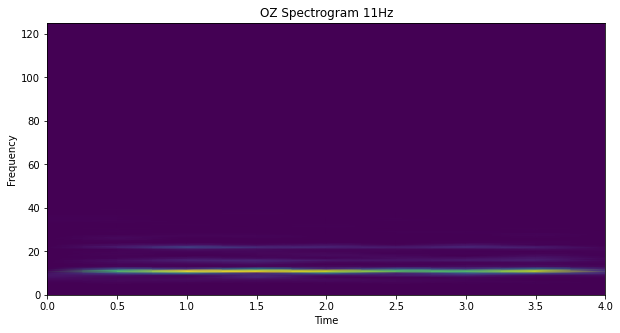

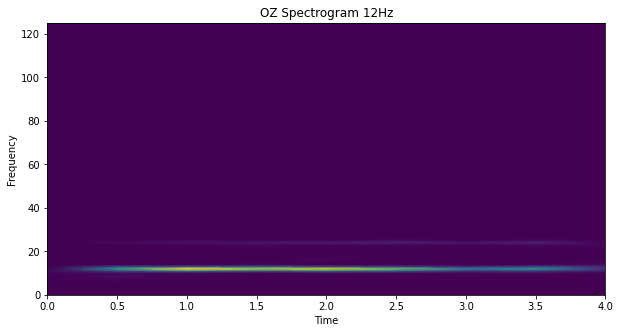

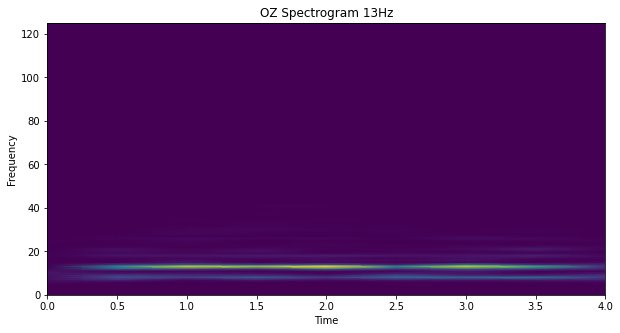

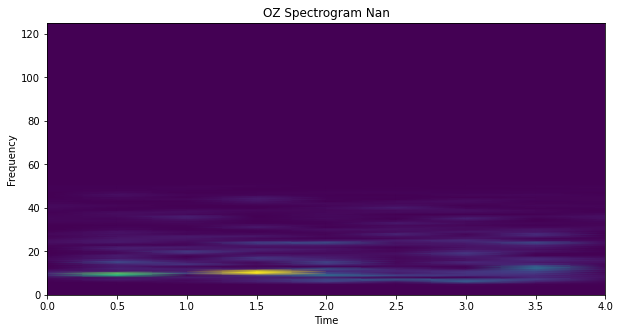

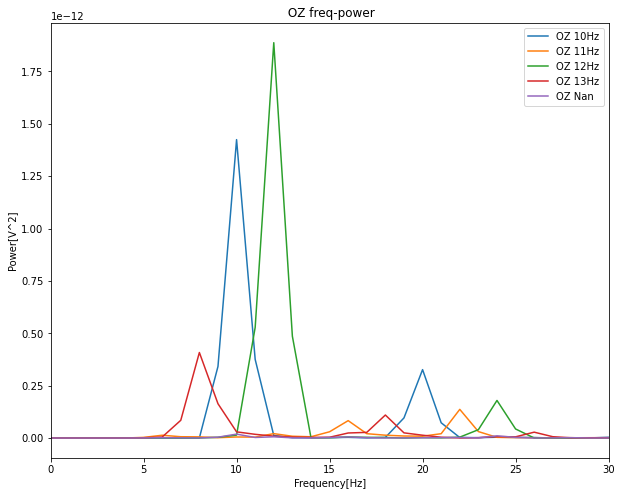

In [43]:
# fz freq-power 
for i in raw.event_id.keys():
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    FZ_data = np.squeeze(FZ[i].average()._data)
       
    f, t, Zxx = signal.stft(FZ_data,
                                    fs=250, window= 'hann',nperseg=250, noverlap= 250/2)
    ax.pcolormesh(t, f,abs(Zxx)**2, shading='gouraud')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Time')
    plt.title('FZ Spectrogram '+ i)
    plt.show()
    
plt.figure(figsize=(10,8))
plt.title(' FZ freq-power ')
plt.ylabel('Power[V^2]')
plt.xlabel('Frequency[Hz]')
plt.xlim([0,30])

for i in raw.event_id.keys():
    FZ_data= np.squeeze(FZ[i].average()._data)
    f, t, Zxx = signal.stft(FZ_data,
                            fs=250, window= 'hann',nperseg=250, noverlap= 250/2)
    Zxx = Zxx.mean(1) 
    plt.plot(f,abs(Zxx)**2)
    
plt.legend(['FZ '+ str(i) for i in raw.event_id.keys()])
    
#OZ freq-power     
for i in raw.event_id.keys():
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    OZ_data= np.squeeze(OZ[i].average()._data)
    f, t, Zxx = signal.stft(OZ_data,
                                    fs=250, window= 'hann',nperseg=250, noverlap= 250/2)

    ax.pcolormesh(t, f,abs(Zxx)**2, shading='gouraud')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Time')
    plt.title('OZ Spectrogram '+ i)
    plt.show()

#Line Chart of OZ
plt.figure(figsize=(10,8))
plt.title(' OZ freq-power')
plt.ylabel('Power[V^2]')
plt.xlabel('Frequency[Hz]')


for i in raw.event_id.keys():
    OZ_data= np.squeeze(OZ[i].average()._data)
    f, t, Zxx = signal.stft(OZ_data,
                            fs=250, window= 'hann',nperseg=250, noverlap= 250/2)
    
    Zxx = Zxx.mean(1) 
    plt.plot(f,abs(Zxx)**2)
    
plt.xlim([0,30])
plt.legend(['OZ '+ str(i) for i in raw.event_id.keys()])


In [44]:
# observations

### c) Plot topolot of response Hz v.s. stimuli Hz with same Min-Max normalization technique

In [46]:
#get eletrode location
location= raw.get_montage().get_positions()['ch_pos']
position= np.zeros((len(location),3))
j=0
for i in raw.ch_names:
    position[j,:]= location[i]
    j+=1

(30, 4, 5)


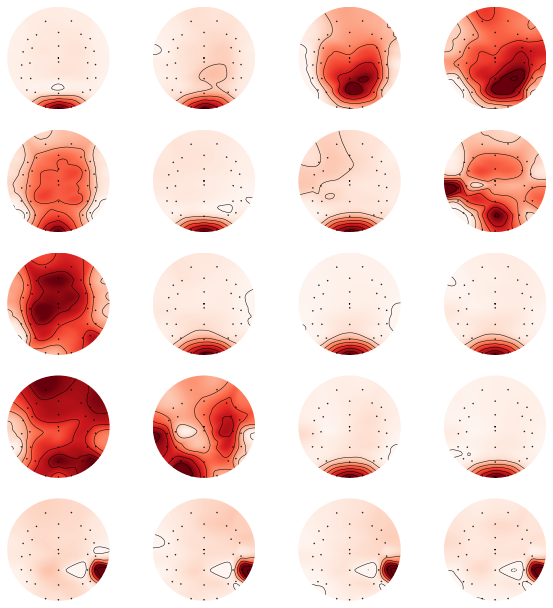

In [47]:
flag=-1
fig, big_axes = plt.subplots(5, 4, figsize=(10, 10))

data = np.zeros([30,4,5])
for i in raw.event_id.keys():
    sti_hz= raw[i].average()._data
    f, Pxx = signal.welch(sti_hz,fs=250, nfft=250, window= 'hann',nperseg=250, noverlap= 250/2)
    flag+=1
    data[:,:,flag]= Pxx[:,10:14]
   
    

rep_min_Hz  = min(data.reshape(-1))
rep_max_Hz= max(data.reshape(-1))
rep= (data-rep_min_Hz)/(rep_max_Hz-rep_min_Hz)    
print(rep.shape)
 
for i in range(4):
    for j in range(5):
        mne.viz.plot_topomap(data=rep[:,i,j], pos=position[:,0:2], axes=big_axes[j,i], show=False)